In [73]:
import websocket
import json
import time
import threading
import uuid
import pandas as pd
from datetime import datetime
import logging

class TradingViewDataFetcher:
    def __init__(self, log_level=logging.WARNING):
        """
        Initialize the TradingView data fetcher with configurable logging.
        
        Args:
            log_level: Logging level (default: WARNING to suppress info messages)
        """
        logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        
        # Default WebSocket URL (can be changed if needed)
        self.ws_url = "wss://prodata.tradingview.com/socket.io/websocket"
        
        # Default headers
        self.headers = {
            "Origin": "https://www.tradingview.com",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

    def fetch_data(self, symbol, exchange="NASDAQ", interval="D", num_bars=100, timeout=20, alt_urls=None):
        """
        Fetch historical price data from TradingView.
        
        Args:
            symbol: Trading symbol (e.g., "AAPL")
            exchange: Exchange name (e.g., "NASDAQ")
            interval: Time interval (e.g., "D" for daily, "W" for weekly, "M" for monthly, 
                     or "1" for 1 minute, "5" for 5 minutes, etc.)
            num_bars: Number of bars to request
            timeout: Maximum time to wait for data in seconds
            alt_urls: List of alternative WebSocket URLs to try if the primary fails
            
        Returns:
            pandas.DataFrame: DataFrame containing OHLCV data
        """
        urls_to_try = [self.ws_url]
        if alt_urls:
            urls_to_try.extend(alt_urls)
        
        for url in urls_to_try:
            self.logger.info(f"Trying WebSocket URL: {url}")
            
            # Reset state for each attempt
            self.session_id = f"qs_{uuid.uuid4().hex[:12]}"
            self.chart_session = f"cs_{uuid.uuid4().hex[:12]}"
            self.received_data = []
            self.error_occurred = False
            
            # Create and start WebSocket
            websocket.enableTrace(False)  # Set to True for verbose WebSocket logs
            ws = websocket.WebSocketApp(
                url,
                header=[f"{k}: {v}" for k, v in self.headers.items()],
                on_open=self._on_open(symbol, exchange, interval, num_bars),
                on_message=self._on_message,
                on_error=self._on_error,
                on_close=self._on_close
            )
            
            wst = threading.Thread(target=ws.run_forever)
            wst.daemon = True
            wst.start()
            
            try:
                # Wait for data
                start_time = time.time()
                while time.time() - start_time < timeout:
                    if self.error_occurred:
                        self.logger.error("Connection error detected, trying next URL if available")
                        break
                    
                    if len(self.received_data) >= num_bars/2:
                        self.logger.info(f"Received sufficient data: {len(self.received_data)} bars")
                        break
                        
                    time.sleep(0.5)
                
                # If we have data, process and return it
                if self.received_data:
                    ws.close()
                    return self._process_data()
                
            except KeyboardInterrupt:
                self.logger.info("Interrupted by user")
            finally:
                ws.close()
        
        # If we get here, all URLs failed
        self.logger.error("Failed to retrieve data from all WebSocket URLs")
        return None

    def _process_data(self):
        """Process the received data into a DataFrame."""
        df = pd.DataFrame(self.received_data)
        if not df.empty:
            df['Date'] = pd.to_datetime(df['Date'], unit='s')
            df = df.sort_values('Date')
            #df.set_index('Date', inplace=True)
            return df
        return None

    def _on_open(self, symbol, exchange, interval, num_bars):
        """Prepare the on_open callback with the required parameters."""
        def on_open_callback(ws):
            self.logger.info("WebSocket connection established")
            
            def run():
                try:
                    self._send_message(ws, "set_auth_token", ["unauthorized_user_token"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_session", [self.chart_session, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "switch_timezone", [self.chart_session, "Etc/UTC"])
                    time.sleep(0.2)
                    
                    full_symbol = f"{exchange}:{symbol}"
                    symbol_payload = json.dumps({"symbol": full_symbol, "adjustment": "splits"})
                    self._send_message(ws, "resolve_symbol", [self.chart_session, "symbol_1", f"={symbol_payload}"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "create_series", [self.chart_session, "s1", "s1", "symbol_1", interval, num_bars, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_study", [self.chart_session, "st1", "st1", "sds_1", full_symbol, interval, num_bars, ""])
                    
                    self.logger.info(f"Requested {num_bars} {interval} bars for {full_symbol}")
                except Exception as e:
                    self.logger.error(f"Error in initialization sequence: {e}")
            
            thread = threading.Thread(target=run)
            thread.daemon = True
            thread.start()
        
        return on_open_callback

    def _send_message(self, ws, method, params):
        """Send a properly formatted message to TradingView WebSocket."""
        try:
            data = json.dumps({"m": method, "p": params})
            message = f"~m~{len(data)}~m~{data}"
            ws.send(message)
            self.logger.debug(f"Sent: {method} - {params[:50]}{'...' if len(str(params)) > 50 else ''}")
        except Exception as e:
            self.logger.error(f"Error sending message {method}: {e}")

    def _on_message(self, ws, message):
        """Handle incoming WebSocket messages."""
        if message == "~h~":
            self.logger.debug("Received heartbeat, sending pong")
            ws.send("~h~")
            return
        
        if not message.startswith("~m~"):
            return
        
        try:
            msg_parts = message.split("~m~")
            for i in range(0, len(msg_parts)):
                if msg_parts[i] and msg_parts[i].isdigit() and i + 1 < len(msg_parts):
                    content = msg_parts[i+1]
                    if content and content.startswith("{"):
                        try:
                            data = json.loads(content)
                            
                            if isinstance(data, dict) and data.get("m") == "timescale_update":
                                self.logger.debug("Found timescale_update message")
                                payload = data.get("p", [])
                                if len(payload) > 1 and isinstance(payload[1], dict):
                                    for series_id, series_data in payload[1].items():
                                        if "s" in series_data and isinstance(series_data["s"], list):
                                            bars_count = len(series_data["s"])
                                            self.logger.debug(f"Found {bars_count} price bars")
                                            
                                            for bar in series_data["s"]:
                                                if "v" in bar and len(bar["v"]) >= 5:
                                                    ts, o, h, l, c = bar["v"][:5]
                                                    volume = bar["v"][5] if len(bar["v"]) > 5 else None
                                                    self.received_data.append({
                                                        "Date": ts,
                                                        "Open": o,
                                                        "High": h,
                                                        "Low": l,
                                                        "Close": c,
                                                        "Volume": volume
                                                    })
                        except json.JSONDecodeError:
                            self.logger.debug(f"Failed to parse JSON: {content[:50]}...")
        except Exception as e:
            self.logger.error(f"Error processing message: {e}")

    def _on_error(self, ws, error):
        """Handle WebSocket errors."""
        self.error_occurred = True
        self.logger.error(f"WebSocket error: {error}")

    def _on_close(self, ws, close_status_code, close_msg):
        """Handle WebSocket connection close."""
        self.logger.debug(f"WebSocket closed: {close_status_code} - {close_msg}")


# Example usage
def get_data(symbol, exchange="NASDAQ", interval="D", bars=5000, log_level=logging.WARNING):
    """
    Simple function to fetch data from TradingView.
    
    Args:
        symbol: Trading symbol (e.g., "AAPL")
        exchange: Exchange name (default: "NASDAQ")
        interval: Time interval (default: "D" for daily)
        bars: Number of bars to request (default: 5000)
        log_level: Logging level (default: WARNING - minimal output)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data or None if failure
    """
    fetcher = TradingViewDataFetcher(log_level=log_level)
    
    # Alternative URLs to try if the primary fails
    alt_urls = [
        "wss://data.tradingview.com/socket.io/websocket",
        "wss://s.tradingview.com/socket.io/websocket"
    ]
    
    return fetcher.fetch_data(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        num_bars=bars,
        alt_urls=alt_urls
    )
import re 

def occ_to_yahoo(occ):
    """
    Convert OCC option symbol (e.g., TSLA250613P00300000) to Yahoo format (e.g., TSLA250613P300.0).
    Handles tickers of any length and all valid strike formats, always includes one decimal.
    """
    m = re.match(r'^([A-Z0-9]{1,6})(\d{6})([CP])(\d{8})$', occ)
    if not m:
        raise ValueError("Invalid OCC option symbol format")
    symbol, date, opt_type, strike_raw = m.groups()
    strike = int(strike_raw) / 1000
    strike_str = f"{strike:.1f}"  # Always one decimal place

    yahoo = f"{symbol}{date}{opt_type}{strike_str}"
    return yahoo




In [ ]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows

## Fetching options chain for a specific ticker
ticker = "GOOG"
expiry = "2025-06-20"  



['2025-06-20' '2025-06-27' '2025-07-03' '2025-07-11' '2025-07-18'
 '2025-07-25' '2025-08-01' '2025-08-15' '2025-09-19' '2025-10-17'
 '2025-11-21' '2025-12-19' '2026-01-16' '2026-03-20' '2026-06-18'
 '2026-09-18' '2026-12-18' '2027-01-15' '2027-06-17' '2027-12-17']
GOOG Current price : 177.635
Exchange : NMS


In [75]:
import pandas as pd
import time
import hashlib

# Initialize an empty DataFrame to hold all appended data
data = pd.DataFrame()

# Store the last clipboard hash to detect changes
last_clipboard_hash = None

def process_clipboard():
    global data, last_clipboard_hash

    # Read clipboard content as raw text
    clipboard_text = pd.read_clipboard(sep=None).to_csv(index=False, header=False)


    # Hash clipboard content to detect changes
    current_hash = hashlib.md5(clipboard_text.encode('utf-8')).hexdigest()

    if current_hash == last_clipboard_hash:
        # No change in clipboard, skip processing
        return

    # Update last clipboard hash
    last_clipboard_hash = current_hash

    # Load clipboard data into DataFrame
    df = pd.read_clipboard()

    # Split the single column into multiple columns by comma
    df_split = df.iloc[:, 0].str.split(',', expand=True)

    # Remove quotes safely from all cells
    df_split = df_split.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

    # Select only Date, Open, High, Low, Close, and Volume columns by their positions
    selected_cols = [0, 1, 2, 3, 4, 7]
    df_selected = df_split.iloc[:, selected_cols]

    # Rename columns accordingly
    df_selected.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    # Convert 'Date' to datetime
    df_selected['Date'] = pd.to_datetime(df_selected['Date'])

    # Convert price and volume columns to numeric, coercing errors to NaN
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce')

    # Set 'Date' as index
    df_selected = df_selected.set_index('Date')

    # Append only new rows with datetime index not already in data
    if not data.empty:
        new_data = df_selected.loc[~df_selected.index.isin(data.index)]
        if not new_data.empty:
            data = pd.concat([data, new_data]).sort_index()
    else:
        data = df_selected

    print(f"Appended {len(df_selected)} rows, total rows: {len(data)}")
    print("\nLatest 10 records:")
    print(data.tail(10))
    print("\n---")

# Run every minute
while True:
    try:
        process_clipboard()
    except Exception as e:
        print(f"Error processing clipboard: {e}")
    time.sleep(20)  # wait 20 seconds before checking again



Error processing clipboard: Expected 4 fields in line 12, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


Error processing clipboard: Expected 4 fields in line 12, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Error processing clipboard: Expected 4 fields in line 12, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Error processing clipboard: Expected 4 fields in line 12, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Error processing clipboard: Expected 4 fields in line 12, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Error processing clipboard: Expected 4 fields in line 12, saw 7. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_97582/765291309.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_split = df_split.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_97582/765291309.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Date'] = pd.to_datetime(df_selected['Date'])
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_97582/765291309.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Appended 1776 rows, total rows: 1776

Latest 10 records:
                           Open  High   Low  Close  Volume
Date                                                      
2025-06-17 17:52:00+00:00  0.85  0.88  0.85   0.88      10
2025-06-17 17:58:00+00:00  0.85  0.85  0.85   0.85       2
2025-06-17 18:00:00+00:00  0.82  0.82  0.79   0.79       9
2025-06-17 18:01:00+00:00  0.81  0.82  0.81   0.81      36
2025-06-17 18:02:00+00:00  0.82  0.82  0.81   0.82     135
2025-06-17 18:05:00+00:00  0.84  0.84  0.84   0.84       3
2025-06-17 18:06:00+00:00  0.88  0.88  0.88   0.88       1
2025-06-17 18:07:00+00:00  0.87  0.87  0.85   0.85       3
2025-06-17 18:08:00+00:00  0.88  0.88  0.88   0.88       1
2025-06-17 18:11:00+00:00  0.88  0.88  0.88   0.88       8

---


KeyboardInterrupt: 

In [76]:


data.index = data.index - pd.Timedelta(hours=4)
data.tail(10)

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-17 13:52:00+00:00,0.85,0.88,0.85,0.88,10
2025-06-17 13:58:00+00:00,0.85,0.85,0.85,0.85,2
2025-06-17 14:00:00+00:00,0.82,0.82,0.79,0.79,9
2025-06-17 14:01:00+00:00,0.81,0.82,0.81,0.81,36
2025-06-17 14:02:00+00:00,0.82,0.82,0.81,0.82,135
2025-06-17 14:05:00+00:00,0.84,0.84,0.84,0.84,3
2025-06-17 14:06:00+00:00,0.88,0.88,0.88,0.88,1
2025-06-17 14:07:00+00:00,0.87,0.87,0.85,0.85,3
2025-06-17 14:08:00+00:00,0.88,0.88,0.88,0.88,1


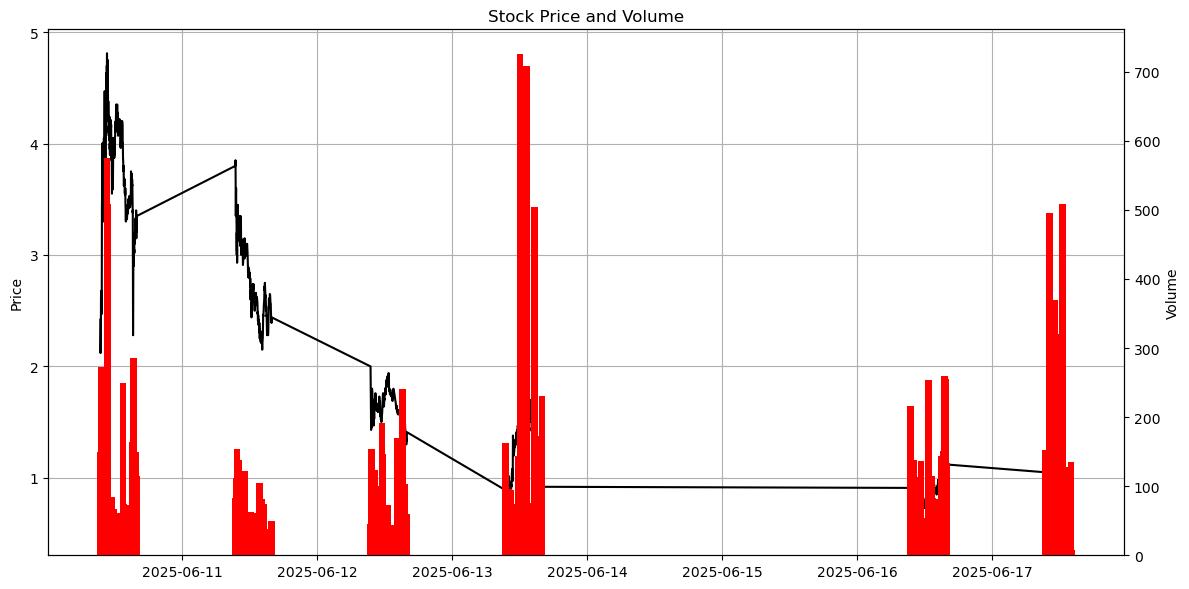

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-17 13:52:00+00:00,0.85,0.88,0.85,0.88,10
2025-06-17 13:58:00+00:00,0.85,0.85,0.85,0.85,2
2025-06-17 14:00:00+00:00,0.82,0.82,0.79,0.79,9
2025-06-17 14:01:00+00:00,0.81,0.82,0.81,0.81,36
2025-06-17 14:02:00+00:00,0.82,0.82,0.81,0.82,135
2025-06-17 14:05:00+00:00,0.84,0.84,0.84,0.84,3
2025-06-17 14:06:00+00:00,0.88,0.88,0.88,0.88,1
2025-06-17 14:07:00+00:00,0.87,0.87,0.85,0.85,3
2025-06-17 14:08:00+00:00,0.88,0.88,0.88,0.88,1


In [77]:

import pandas as pd
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing price
ax1.plot(data.index, data['Close'], color='black', label='Close Price')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Stock Price and Volume')
ax1.grid(True)

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.bar(data.index, data['Volume'], color='red', alpha=1, label='Volume', width =0.05)
ax2.set_ylabel('Volume', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.show()

data.tail(10)

In [78]:
from IPython.display import display, HTML

# Get the last 10 rows as HTML
html_table = data.to_html()

# Wrap in a scrollable div
scrollable_html = f'''
<div style="max-height:300px; overflow:auto; border:1px solid #ccc;">
    {html_table}
</div>
'''

display(HTML(scrollable_html))


,Open,High,Low,Close,Volume
Date,,,,,
2025-06-10 09:30:00+00:00,2.33,2.45,2.33,2.42,95
2025-06-10 09:31:00+00:00,2.37,2.37,2.12,2.12,51
2025-06-10 09:32:00+00:00,2.13,2.25,2.13,2.25,17
2025-06-10 09:33:00+00:00,2.30,2.30,2.23,2.26,12
2025-06-10 09:34:00+00:00,2.28,2.35,2.23,2.34,150
2025-06-10 09:35:00+00:00,2.29,2.45,2.29,2.42,32
2025-06-10 09:36:00+00:00,2.47,2.63,2.47,2.62,36
2025-06-10 09:37:00+00:00,2.63,2.63,2.52,2.52,66
2025-06-10 09:38:00+00:00,2.44,2.50,2.44,2.47,79


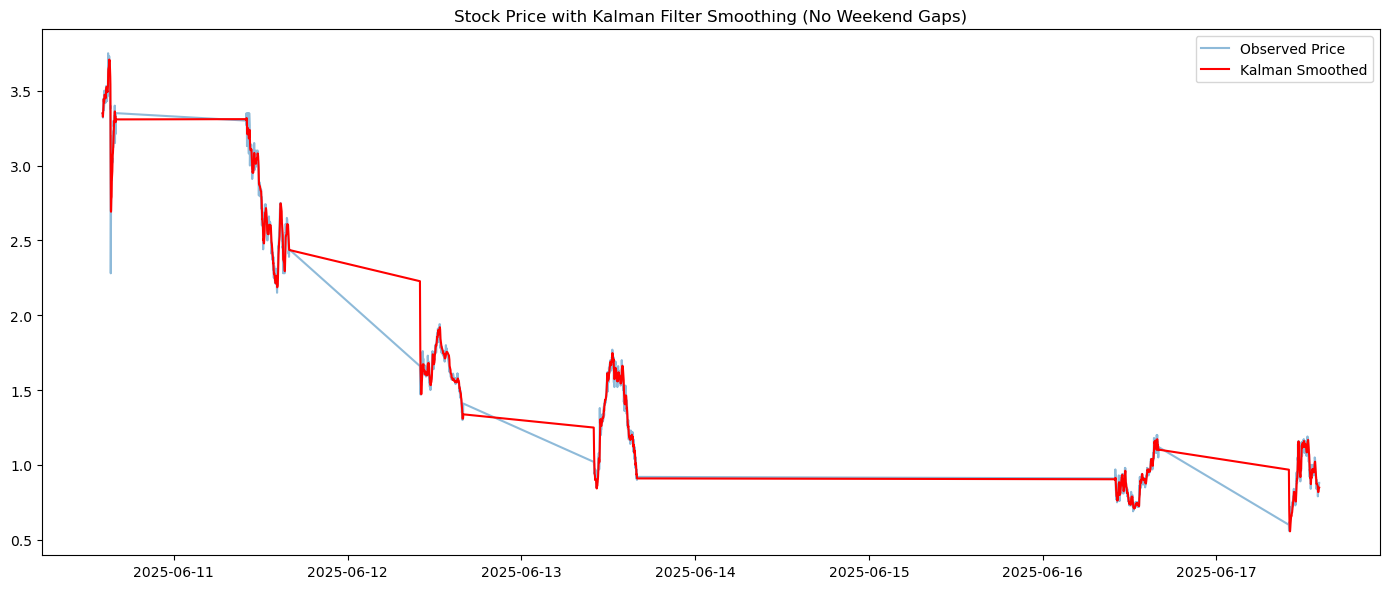

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
##___________________________________________________________________________________________________________________________________________________________________________________
days = 7 # or 7 for a full week
##___________________________________________________________________________________________________________________________________________________________________________________
# --- Data Preparation ---

# Remove weekends and keep only regular trading hours
datafix = data[data.index.weekday < 5]
datafix = datafix[(datafix.index.hour < 16) & (datafix.index.hour > 9)]

# Filter for only the last N days in the data
last_date = datafix.index.max()
timer = last_date - pd.Timedelta(days=days)
datafix = datafix[datafix.index >= timer]

# Ensure index is DatetimeIndex
datafix.index = pd.to_datetime(datafix.index)

# --- Kalman Filter Price ---

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([datafix['Close'].iloc[0], 0.])  # initial state (price, velocity)
kf.F = np.array([[1., .1], [0., 1.]])            # state transition matrix
kf.H = np.array([[1., 0.]])                      # measurement function
kf.P *= 1000.                                    # covariance matrix
kf.R = 1.                                        # measurement noise
kf.Q = np.eye(2)*0.05                            # process noise

filtered_state_means = []
for price in datafix['Close']:
    kf.predict()
    kf.update(price)
    filtered_state_means.append(kf.x[0])

datafix['Kalman'] = filtered_state_means

# --- Plotting ---

plt.figure(figsize=(14,6))
plt.plot(datafix.index, datafix['Close'], label='Observed Price', alpha=0.5)
plt.plot(datafix.index, datafix['Kalman'], label='Kalman Smoothed', color='red')
plt.title('Stock Price with Kalman Filter Smoothing (No Weekend Gaps)')
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
##KALMAN FILTER ROC
datafix["Kalman_Roc"] = datafix['Kalman'].pct_change().dropna() * 100  # Convert to percentage change
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc
Date,,,,,,,
2025-06-17 13:52:00+00:00,0.85,0.88,0.85,0.88,10,0.872316,-0.311643
2025-06-17 13:58:00+00:00,0.85,0.85,0.85,0.85,2,0.862518,-1.123171
2025-06-17 14:00:00+00:00,0.82,0.82,0.79,0.79,9,0.839194,-2.704167
2025-06-17 14:01:00+00:00,0.81,0.82,0.81,0.81,36,0.826393,-1.525432
2025-06-17 14:02:00+00:00,0.82,0.82,0.81,0.82,135,0.819312,-0.856879
2025-06-17 14:05:00+00:00,0.84,0.84,0.84,0.84,3,0.819411,0.012104
2025-06-17 14:06:00+00:00,0.88,0.88,0.88,0.88,1,0.830465,1.349006
2025-06-17 14:07:00+00:00,0.87,0.87,0.85,0.85,3,0.831604,0.137106
2025-06-17 14:08:00+00:00,0.88,0.88,0.88,0.88,1,0.840733,1.097839


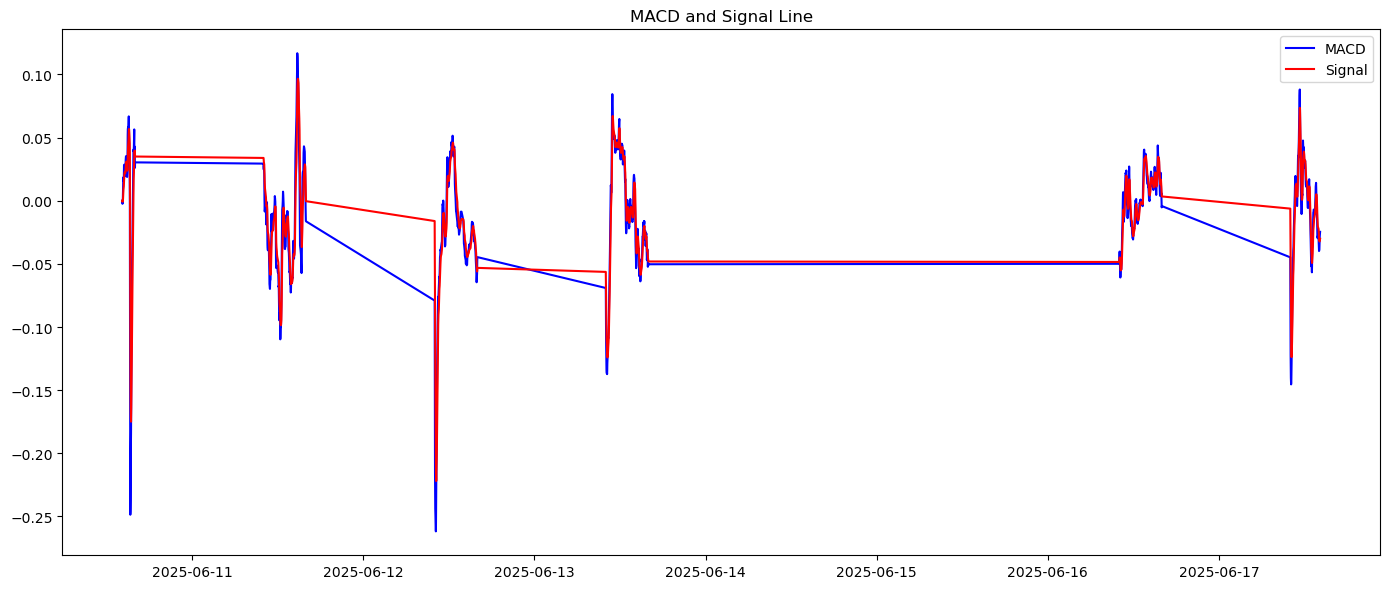

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist
Date,,,,,,,,,,
2025-06-10 14:11:00+00:00,3.39,3.39,3.35,3.35,12,3.350000,NaN,0.000000,0.000000,0.000000
2025-06-10 14:12:00+00:00,3.35,3.35,3.35,3.35,39,3.350000,0.000000,0.000000,0.000000,0.000000
2025-06-10 14:13:00+00:00,3.32,3.33,3.32,3.32,11,3.325641,-0.727123,-0.002393,-0.000479,-0.001915
2025-06-10 14:14:00+00:00,3.36,3.36,3.35,3.35,7,3.338338,0.381790,-0.001848,-0.000752,-0.001095
2025-06-10 14:16:00+00:00,3.38,3.39,3.38,3.38,9,3.362521,0.724394,0.000994,-0.000403,0.001397
2025-06-10 14:17:00+00:00,3.40,3.40,3.40,3.40,5,3.385468,0.682425,0.004804,0.000638,0.004166
2025-06-10 14:18:00+00:00,3.43,3.44,3.41,3.41,58,3.402783,0.511458,0.008533,0.002217,0.006315
2025-06-10 14:19:00+00:00,3.45,3.45,3.43,3.44,10,3.426003,0.682387,0.013750,0.004524,0.009226
2025-06-10 14:20:00+00:00,3.45,3.45,3.45,3.45,1,3.444232,0.532071,0.018478,0.007315,0.011163


In [81]:
#MACD
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACD'] = macd
    df['Signal'] = signal_line
    df['MACD_Hist'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Close', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Hist']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(macdata.index, macdata['MACD'], label='MACD', color='blue')
plt.plot(macdata.index, macdata['Signal'], label='Signal', color='red')
plt.title('MACD and Signal Line')
plt.legend()
plt.tight_layout()
plt.show()


macdata.head(10)


In [82]:
import pandas as pd

## adjusting strike price for the contract

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2025, 6, 9)

# DGS1MO is the FRED code for the 1-Month Treasury Constant Maturity Rate
rate = web.DataReader('DGS1MO', 'fred', start, end)
rfr = rate.iloc[-1, 0]  # Last available value as a scalar



In [83]:
import pandas as pd

dateexpiry = "2025-06-20"
expiry = pd.Timestamp(dateexpiry)

# Ensure the index is timezone-naive to avoid subtraction errors
datafix.index = datafix.index.tz_localize(None)

# Calculate days to expiry
datafix['days_to_expiry'] = (expiry - datafix.index).days.astype(float) + 1

print(datafix['days_to_expiry'].tail(1))

# Continue with your display logic




Date
2025-06-17 14:11:00    3.0
Name: days_to_expiry, dtype: float64


In [84]:
num_bars = len(datafix)

# Fetch exactly as many bars as there are rows in datafix
stockdata = get_data(ticker, exchange="NASDAQ", interval="1", bars=num_bars)



In [85]:
stockdata.tail(10)

,Date,Open,High,Low,Close,Volume
1376,2025-06-17 18:03:00,177.490,177.54,177.44,177.46,1033.0
1377,2025-06-17 18:04:00,177.440,177.50,177.42,177.49,2693.0
1378,2025-06-17 18:05:00,177.500,177.63,177.50,177.63,2472.0
1379,2025-06-17 18:06:00,177.640,177.68,177.58,177.59,2343.0
1380,2025-06-17 18:07:00,177.580,177.70,177.57,177.69,915.0
1381,2025-06-17 18:08:00,177.660,177.67,177.57,177.57,2158.0
1382,2025-06-17 18:09:00,177.580,177.64,177.56,177.63,2251.0
1383,2025-06-17 18:10:00,177.630,177.73,177.62,177.71,2568.0
1384,2025-06-17 18:11:00,177.695,177.70,177.65,177.70,798.0
1385,2025-06-17 18:12:00,177.680,177.69,177.57,177.57,521.0


In [86]:
import pandas as pd

# Adjust stockdata['Date'] and set as index
stockdata["Date"] = pd.to_datetime(stockdata["Date"]) - pd.Timedelta(hours=4)
stockdata = stockdata.set_index("Date").sort_index()
stockdata["stock price"] = stockdata["Close"]

# Ensure datafix index is datetime and sorted
datafix.index = pd.to_datetime(datafix.index)
datafix = datafix.sort_index()

# Use merge_asof with suffixes to control column names
merged = pd.merge_asof(
    datafix,
    stockdata[["Close"]],
    left_index=True,
    right_index=True,
    direction="nearest",
    suffixes=('_datafix', '_stock')
)

# Rename columns: Close_datafix → Close, Close_stock → stock price
merged = merged.rename(columns={
    'Close_datafix': 'Close',
    'Close_stock': 'stock price'
})

# Assign merged DataFrame back to datafix
datafix = merged

# Show the last 10 rows
datafix.tail(10)


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price
Date,,,,,,,,,,,,
2025-06-17 13:52:00,0.85,0.88,0.85,0.88,10,0.872316,-0.311643,-0.027990,-0.020383,-0.007607,3.0,177.60
2025-06-17 13:58:00,0.85,0.85,0.85,0.85,2,0.862518,-1.123171,-0.030067,-0.022320,-0.007747,3.0,177.60
2025-06-17 14:00:00,0.82,0.82,0.79,0.79,9,0.839194,-2.704167,-0.036137,-0.025083,-0.011054,3.0,177.50
2025-06-17 14:01:00,0.81,0.82,0.81,0.81,36,0.826393,-1.525432,-0.038886,-0.027844,-0.011042,3.0,177.53
2025-06-17 14:02:00,0.82,0.82,0.81,0.82,135,0.819312,-0.856879,-0.039799,-0.030235,-0.009564,3.0,177.49
2025-06-17 14:05:00,0.84,0.84,0.84,0.84,3,0.819411,0.012104,-0.038465,-0.031881,-0.006584,3.0,177.63
2025-06-17 14:06:00,0.88,0.88,0.88,0.88,1,0.830465,1.349006,-0.033791,-0.032263,-0.001528,3.0,177.59
2025-06-17 14:07:00,0.87,0.87,0.85,0.85,3,0.831604,0.137106,-0.032137,-0.032238,0.000101,3.0,177.69
2025-06-17 14:08:00,0.88,0.88,0.88,0.88,1,0.840733,1.097839,-0.028082,-0.031407,0.003325,3.0,177.57


In [87]:



# set strike for black scholes 
datafix['strike'] = 180  
datafix['rfr'] = rfr/100
# Define the type of option
datafix["type"] = "c"
##___________________________________________________________________________________________________________________________________________________________________________________


In [88]:


import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_price(S, K, T, r, sigma, option_type='c'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility_row(row):
    price = row['Close']
    S = row['stock price']
    K = row['strike']
    T = row['days_to_expiry'] / 365.0
    r = row['rfr']
    option_type = row['type']  # 'c' for call, 'p' for put

    # Objective function for root finding
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - price

    try:
        return brentq(objective, 1e-6, 5.0)
    except Exception:
        return np.nan

datafix['IV'] = datafix.apply(implied_volatility_row, axis=1)



In [89]:
datafix["IVROC"] = datafix["IV"].pct_change().dropna() * 100  # Convert to percentage change
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC
Date,,,,,,,,,,,,,,,,,
2025-06-17 13:52:00,0.85,0.88,0.85,0.88,10,0.872316,-0.311643,-0.027990,-0.020383,-0.007607,3.0,177.60,180,0.0429,c,0.280553,-2.915296
2025-06-17 13:58:00,0.85,0.85,0.85,0.85,2,0.862518,-1.123171,-0.030067,-0.022320,-0.007747,3.0,177.60,180,0.0429,c,0.275245,-1.892268
2025-06-17 14:00:00,0.82,0.82,0.79,0.79,9,0.839194,-2.704167,-0.036137,-0.025083,-0.011054,3.0,177.50,180,0.0429,c,0.269851,-1.959536
2025-06-17 14:01:00,0.81,0.82,0.81,0.81,36,0.826393,-1.525432,-0.038886,-0.027844,-0.011042,3.0,177.53,180,0.0429,c,0.271861,0.744839
2025-06-17 14:02:00,0.82,0.82,0.81,0.82,135,0.819312,-0.856879,-0.039799,-0.030235,-0.009564,3.0,177.49,180,0.0429,c,0.275789,1.444744
2025-06-17 14:05:00,0.84,0.84,0.84,0.84,3,0.819411,0.012104,-0.038465,-0.031881,-0.006584,3.0,177.63,180,0.0429,c,0.271849,-1.428324
2025-06-17 14:06:00,0.88,0.88,0.88,0.88,1,0.830465,1.349006,-0.033791,-0.032263,-0.001528,3.0,177.59,180,0.0429,c,0.281097,3.401708
2025-06-17 14:07:00,0.87,0.87,0.85,0.85,3,0.831604,0.137106,-0.032137,-0.032238,0.000101,3.0,177.69,180,0.0429,c,0.270365,-3.817749
2025-06-17 14:08:00,0.88,0.88,0.88,0.88,1,0.840733,1.097839,-0.028082,-0.031407,0.003325,3.0,177.57,180,0.0429,c,0.282183,4.371050


In [90]:
# Ensure your index is a DatetimeIndex
datafix.index = pd.to_datetime(datafix.index)

# Filter for weekdays (Monday=0, Sunday=6)
is_weekday = datafix.index.dayofweek < 5

# Filter for regular trading hours (9:30 to 16:00)
is_regular_hours = (
    (datafix.index.hour > 9) & (datafix.index.hour < 16) |  # 10:00 to 15:59
    ((datafix.index.hour == 9) & (datafix.index.minute >= 30)) |  # 9:30 to 9:59
    ((datafix.index.hour == 16) & (datafix.index.minute == 0))    # exactly 16:00
)

# Combine masks
mask = is_weekday & is_regular_hours

# Apply mask to keep only regular trading hours
datafix = datafix.loc[mask]


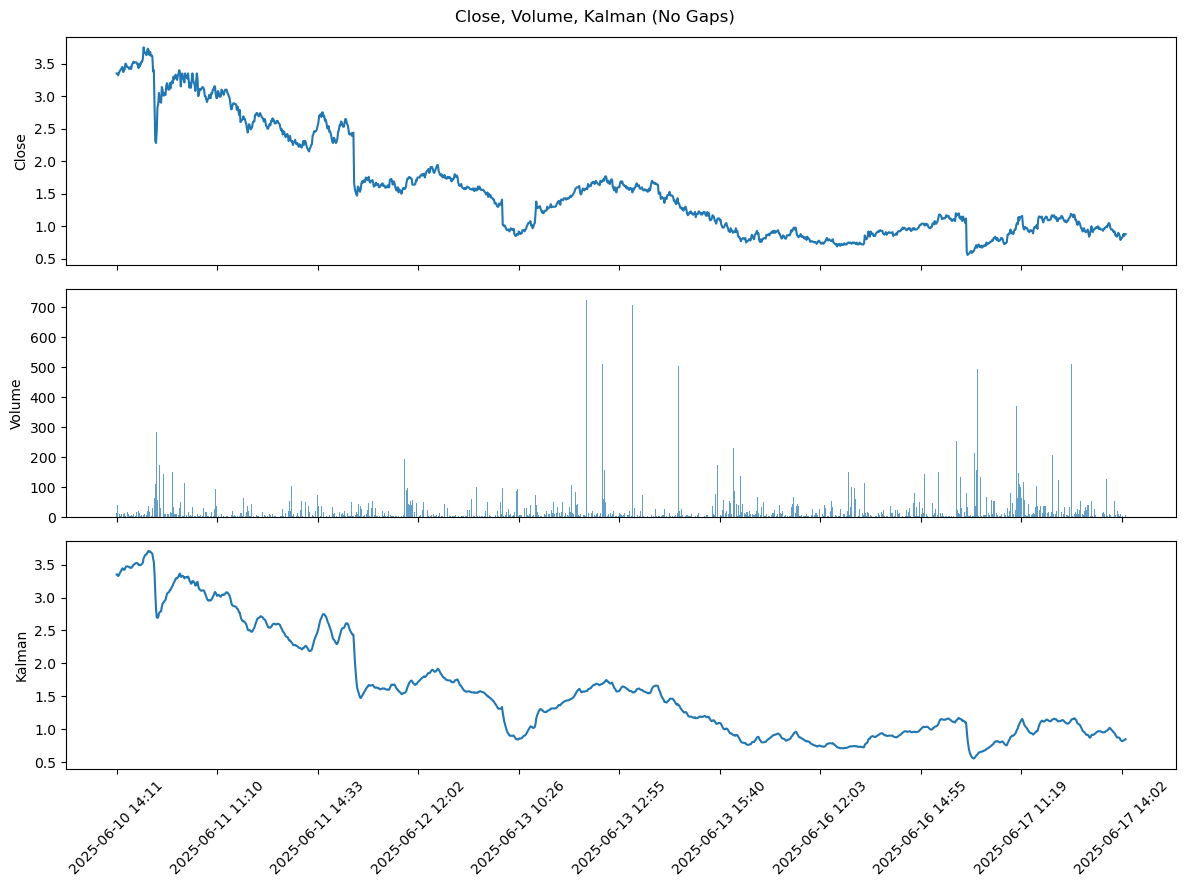

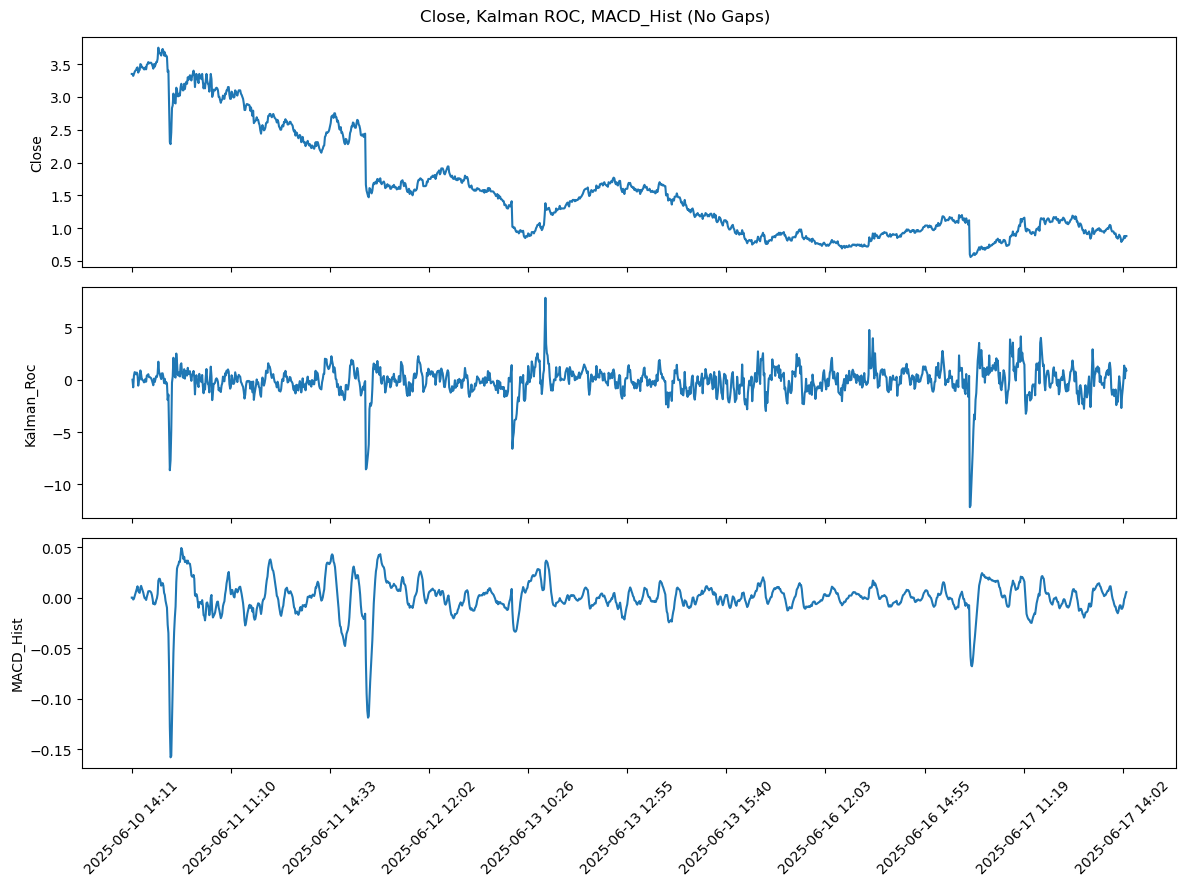

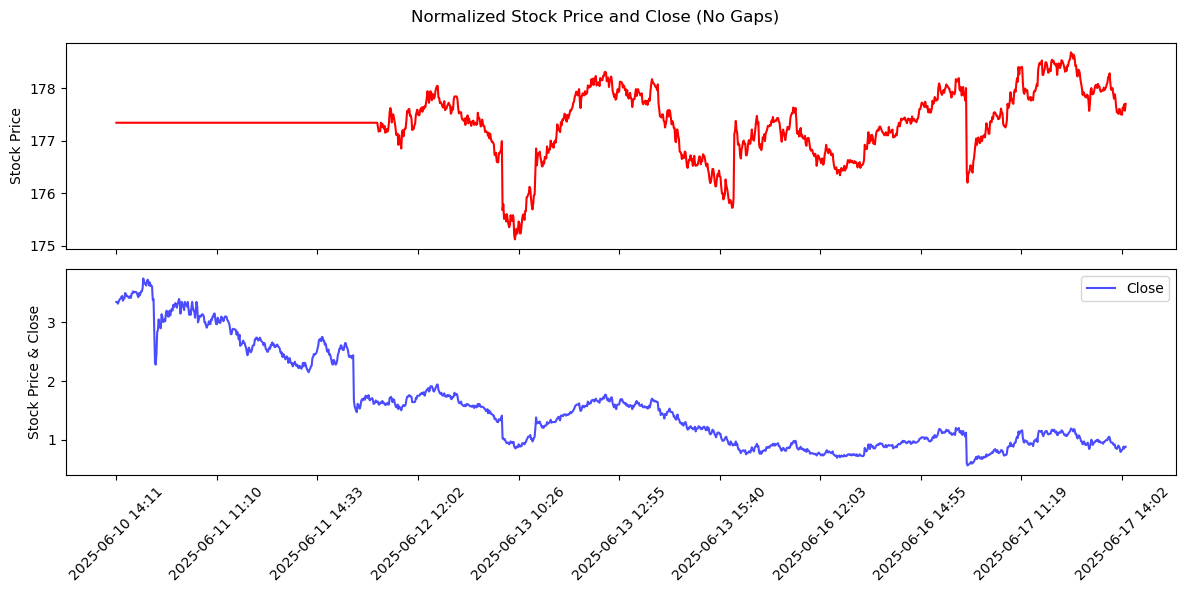

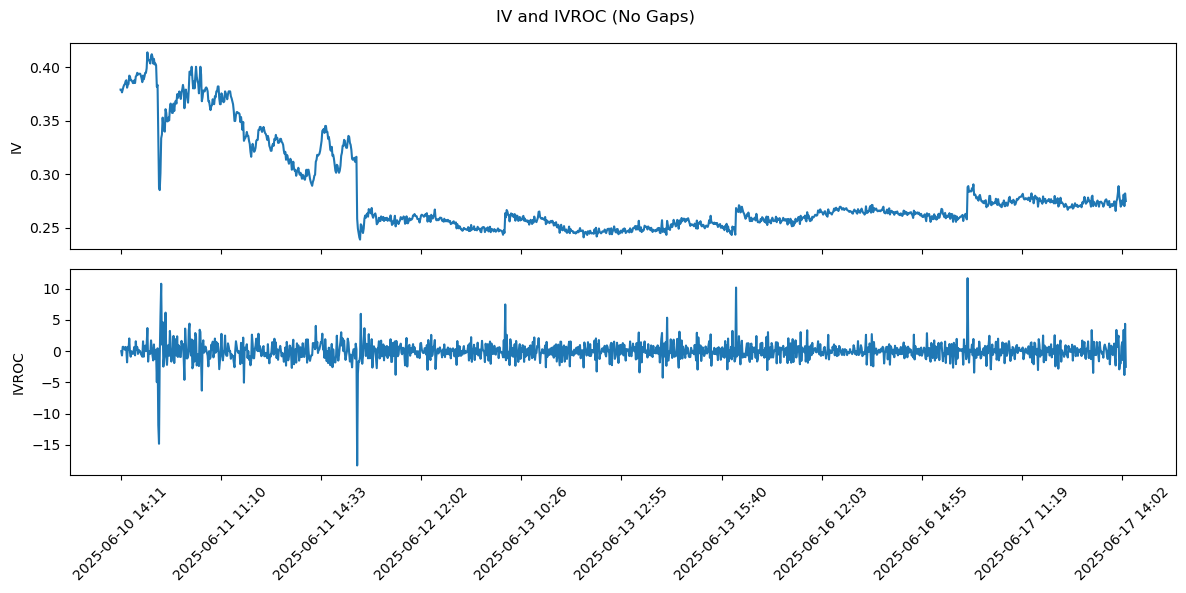

In [91]:
import matplotlib.pyplot as plt

# Reset index and detect the datetime column name
datafix_reset = datafix.reset_index()
datetime_col = datafix_reset.columns[0]  # The first column after reset_index() is always the old index

# For tick labeling, use the datetime column
time_labels = datafix_reset[datetime_col]

# Function to plot with integer index and datetime tick labels
def plot_with_int_index(y_cols, suptitle, kinds=None):
    n = len(y_cols)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)
    if n == 1:
        axs = [axs]
    for i, col in enumerate(y_cols):
        kind = 'line' if not kinds else kinds[i]
        if kind == 'bar':
            axs[i].bar(datafix_reset.index, datafix_reset[col], label=col, alpha=0.7)
        else:
            axs[i].plot(datafix_reset.index, datafix_reset[col], label=col)
        axs[i].set_ylabel(col)
    # Set x-ticks with datetime labels
    step = max(1, len(time_labels) // 10)
    axs[-1].set_xticks(datafix_reset.index[::step])
    axs[-1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# 1. Close, Volume (bar), Kalman
plot_with_int_index(['Close', 'Volume', 'Kalman'], 'Close, Volume, Kalman (No Gaps)', kinds=['line', 'bar', 'line'])

# 2. Close, Kalman_Roc, MACD_Hist (bar)
plot_with_int_index(['Close', 'Kalman_Roc', 'MACD_Hist'], 'Close, Kalman ROC, MACD_Hist (No Gaps)', kinds=['line', 'line', 'line'])
import pandas as pd
from sklearn.preprocessing import StandardScaler
#3. Prices

# Overlay plot: normalized stock price and close
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(datafix_reset.index, datafix['stock price'], label='Stock Price ', color='red')
axs[0].set_ylabel('Stock Price')
axs[1].plot(datafix_reset.index, datafix['Close'], label='Close', color='blue', alpha=0.7)
axs[1].set_ylabel('Stock Price & Close')
axs[1].legend()
step = max(1, len(time_labels) // 10)
axs[1].set_xticks(datafix_reset.index[::step])
axs[1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
plt.suptitle('Normalized Stock Price and Close (No Gaps)')
plt.tight_layout()
plt.show()


# 4. IV, IVROC
plot_with_int_index(['IV', 'IVROC'], 'IV and IVROC (No Gaps)')


In [92]:
# kalman filter (Garch) the IV
# Pull price data from fidelity csv 
# set thresholds 
# figure out papertrade setup 

In [93]:
import os

# Assume 'datafix' is your pandas DataFrame
# import pandas as pd
# datafix = pd.DataFrame(...)  # your DataFrame creation

user_input = input("Download datafix.csv to Desktop? (y/n): ").strip().lower()

if user_input == 'y':
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    file_path = os.path.join(desktop_path, "datafix.csv")
    try:
        datafix.to_csv(file_path, index=True)
        print(f"datafix.csv saved to {file_path} (including index)")
    except Exception as e:
        print(f"Failed to save CSV: {e}")
else:
    print("Download canceled.")


datafix.csv saved to /Users/nshaffer/Desktop/datafix.csv (including index)


In [94]:
# get a garch or volatility measure to make trades when IV is low (and increasing?)